In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import sys, os, os.path, time
import argparse
import numpy as np
import torch
import torch.nn as nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.autograd import Variable
from Net_mModal import Net, NewNet, TransformerEncoder, Transformer, MMTEncoder, LateFusion, videoModel, SuperLateFusion
from util_in_multi_h5_unnorm_AST import *
from util_out import *
from util_f1 import *
from AudioResNet import resnet50
# from AST import ASTModel
from ast_models_original import ASTModel
%matplotlib inline
import subprocess
import pickle

import matplotlib.pyplot as plt
import h5py



ModuleNotFoundError: No module named 'util_in_multi_h5_unnorm_AST'

In [ ]:
curr_node = socket.gethostname().split('.')[0]
batcmd=f"squeue -u billyli | grep {curr_node}"
curr_slurm = subprocess.check_output(batcmd, shell=True, text=True)
slurm_id = curr_slurm.strip().split(' ')[0]
print(slurm_id)

In [ ]:
torch.cuda.is_available()
torch.cuda.device_count()

# VICTIM MODEL

In [4]:
parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)

parser.add_argument("--model_type", type=str, default='ast', help="the model used")
parser.add_argument("--dataset", type=str, default="audioset_s", help="the dataset used", choices=["audioset","audioset_s", "esc50", "speechcommands"])
parser.add_argument("--n_mels", type=int, default=128, help="number of mel bins")
parser.add_argument("--dataset-portion", type=str, default='full', help="balance set or full set")
parser.add_argument('--mean', default=-12.7508, type=float, help='normalizing mean')
parser.add_argument('--std', default=11.7584, type=float, help='normalizing std')

parser.add_argument("--exp-dir", type=str, default="", help="directory to dump experiments")
parser.add_argument('--lr', '--learning-rate', default="0.001", type=str, metavar='LR', help='initial learning rate')
parser.add_argument("--optim", type=str, default="adam", help="training optimizer", choices=["sgd", "adam"])
parser.add_argument('-b', '--batch-size', default=12, type=int, metavar='N', help='mini-batch size')
parser.add_argument('-w', '--num-workers', default=32, type=int, metavar='NW', help='# of workers for dataloading (default: 32)')
parser.add_argument("--n-epochs", type=int, default=1, help="number of maximum training epochs")
# not used in the formal experiments
parser.add_argument("--lr_patience", type=int, default=2, help="how many epoch to wait to reduce lr if mAP doesn't improve")

parser.add_argument("--n-print-steps", type=int, default=100, help="number of steps to print statistics")

parser.add_argument('--freqm', help='frequency mask max length', type=int, default=0)
parser.add_argument('--timem', help='time mask max length', type=int, default=0)
parser.add_argument("--mixup", type=float, default=0, help="how many (0-1) samples need to be mixup during training")
parser.add_argument("--bal", type=str, default=None, help="use balanced sampling or not")
# the stride used in patch spliting, e.g., for patch size 16*16, a stride of 16 means no overlapping, a stride of 10 means overlap of 6.
parser.add_argument("--fstride", type=int, default=8, help="soft split freq stride, overlap=patch_size-stride")
parser.add_argument("--tstride", type=int, default=8, help="soft split time stride, overlap=patch_size-stride")
parser.add_argument('--imagenet_pretrain', help='if use ImageNet pretrained audio spectrogram transformer model', type=bool, default='True')
parser.add_argument('--audioset_pretrain', help='if use ImageNet and audioset pretrained audio spectrogram transformer model', type=bool, default='False')
parser.add_argument('--suffix', type=str, default='')


_StoreAction(option_strings=['--suffix'], dest='suffix', nargs=None, const=None, default='', type=<class 'str'>, choices=None, help=None, metavar=None)

### AST 64x400 best model

In [5]:
args = parser.parse_args(args=['--model_type=AST','--dataset=audioset_s','--n_mels=64', '--mean=-27.248297','--std=37.681698',
                               '--lr=1e-5','--batch-size=80','--n-epochs=10','--fstride=8','--tstride=8',
                               '--freqm=12','--timem=75','--mixup=0.5',
                               '--imagenet_pretrain=True','--suffix=ast_challenge-40.95'])
args.target_length=400
exp_id = f"{args.dataset}-{args.dataset_portion}-f{args.fstride}-t{args.tstride}-p{args.imagenet_pretrain}-b{args.batch_size}-lr{args.lr}\
-fm{args.freqm}-tm{args.timem}-mix{args.mixup}-m{args.mean}-std{args.std}-epoch{args.n_epochs}-{args.suffix}"
print(exp_id)
WORKSPACE = '/jet/home/billyli/data_folder/AllaboutAudioSet_hack/egs/audioset/exp'
MODEL_FILE = os.path.join(WORKSPACE, exp_id, 'models', 'audio_model.9.pth')

audioset_s-full-f8-t8-pTrue-b80-lr1e-5-fm12-tm75-mix0.5-m-27.248297-std37.681698-epoch10-ast_challenge-40.95


### AST 128x1024 best model

In [6]:
# args = parser.parse_args(args=['--model_type=AST','--dataset=audioset','--n_mels=128', '--mean=-3.6788461','--std=4.3739743',
#                                '--lr=1e-5','--batch-size=20','--n-epochs=10','--fstride=10','--tstride=10',
#                                '--freqm=36','--timem=192','--mixup=0.3',
#                                '--imagenet_pretrain=True','--suffix=ast_challenge-43.0'])
# args.target_length=1024
# exp_id = f"{args.dataset}-{args.dataset_portion}-f{args.fstride}-t{args.tstride}-p{args.imagenet_pretrain}-b{args.batch_size}-lr{args.lr}\
# -fm{args.freqm}-tm{args.timem}-mix{args.mixup}-m{args.mean}-std{args.std}-epoch{args.n_epochs}-{args.suffix}"
# print(exp_id)
# WORKSPACE = '/jet/home/billyli/data_folder/AllaboutAudioSet_hack/egs/audioset/exp'
# MODEL_FILE = os.path.join(WORKSPACE, exp_id, 'models', 'audio_model.3.pth')

In [7]:
print(MODEL_FILE)

/jet/home/billyli/data_folder/AllaboutAudioSet_hack/egs/audioset/exp/audioset_s-full-f8-t8-pTrue-b80-lr1e-5-fm12-tm75-mix0.5-m-27.248297-std37.681698-epoch10-ast_challenge-40.95/models/audio_model.9.pth


In [8]:
args

Namespace(audioset_pretrain=True, bal=None, batch_size=80, dataset='audioset_s', dataset_portion='full', exp_dir='', freqm=12, fstride=8, imagenet_pretrain=True, lr='1e-5', lr_patience=2, mean=-27.248297, mixup=0.5, model_type='AST', n_epochs=10, n_mels=64, n_print_steps=100, num_workers=32, optim='adam', std=37.681698, suffix='ast_challenge-40.95', target_length=400, timem=75, tstride=8)

In [9]:
# Load model
#model = Net(args).cuda()
if args.model_type == 'TAL':
    model = Net(args).cuda()
elif args.model_type == 'TAL-trans':
    model = TransformerEncoder(args).cuda()
elif args.model_type == 'TAL-new':
    model = NewNet(args).cuda()
elif args.model_type == 'Trans':
    model = Transformer(args).cuda()
elif args.model_type == 'resnet':
    model = resnet50().cuda()
elif args.model_type == 'MMT':
    model = MMTEncoder(args).cuda()
elif args.model_type == 'VM':
    model = videoModel(args).cuda()
elif args.model_type == 'MMTLF':
    model = LateFusion(args).cuda()
elif args.model_type == 'AST':
    model = ASTModel(label_dim=527, fstride=args.fstride, tstride=args.tstride, input_fdim=args.n_mels, input_tdim=args.target_length, imagenet_pretrain=args.imagenet_pretrain, audioset_pretrain=False).cuda()
else:
    print ('model type not recognized')
    exit(0)


---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: False
input_fdim: 64,input_tdim: 400
out_shape: torch.Size([1, 768, 7, 49])
f_dim: 7,t_dim: 49, num_patches: 343
frequncey stride=8, time stride=8
number of patches=343
pos_embedding reshaped shape: torch.Size([1, 345, 768])

/jet/home/billyli/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [10]:
optimizer = Adam(model.parameters())


In [11]:
prev_ckpt = torch.load(MODEL_FILE)
# start_ckpt = prev_ckpt['epoch']
# scheduler.load_state_dict(prev_ckpt['scheduler'])
# model = nn.DataParallel(model)
temp = {}
for key, val in prev_ckpt.items():
    key = key.replace('module.','')
    temp[key] = val
model.load_state_dict(temp)
# optimizer.load_state_dict(prev_ckpt['optimizer'])
# write_log('Loading model from %s' % args.continue_from_ckpt)
model.eval()

ASTModel(
  (v): DistilledVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(8, 8))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Block(
        (norm1): LayerNorm((768,)

In [12]:
N_CLASSES = 527
N_WORKERS = 6
local = f"/local/slurm-{slurm_id}/local/audio"
if args.dataset == 'audioset_s':
    hf_val_eval_path = os.path.join(local, 'data_64_400_again.h5')
elif args.dataset == 'audioset':
    hf_val_eval_path = os.path.join(local, 'data_128_1024_again.h5')
# hf_val_eval_path = os.path.join(local, 'data_128_1024_strong_cleaned.h5')
mu_val=args.mean
sigma_val=args.std
                            
def bulk_load2(file_path, mu, sigma):
    hf_val_eval = h5py.File(file_path, 'r')
    feat_a = (hf_val_eval['feat_a'][:]*2-mu)/(2 * sigma)
    labels = hf_val_eval['labels'][:]
    hf_val_eval.close()
    return feat_a.astype('float32'), labels.astype('bool')

gas_eval_x1, gas_eval_y = bulk_load2(hf_val_eval_path, mu_val, sigma_val)

In [13]:
gas_eval_x1.shape, gas_eval_y.shape, mu_val, sigma_val

((20123, 400, 64), (20123, 527), -27.248297, 37.681698)

# Inference

In [14]:
result = []
batch_size =100
x = gas_eval_x1 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]


total num of batches during testing 202


In [15]:
print(result[0].shape)

(20123, 527)


In [16]:
gas_eval_global_prob_multi = result[0]

In [17]:
# print(gas_eval_global_prob_multi.shape)

In [18]:
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)

Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------


In [19]:
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

0.41093723164743673 0.8366745745431141 1.3871768682446737
 Average | 0.411 | 0.837 | 1.387 
---------+-------+-------+-------
       0 | 0.874 | 0.916 | 1.951 
       1 | 0.072 | 0.405 |-0.341 
       2 | 0.097 | 0.597 | 0.349 
       3 | 0.375 | 0.754 | 0.970 
       4 | 0.245 | 0.804 | 1.210 
       5 | 0.089 | 0.696 | 0.723 
       6 | 0.474 | 0.966 | 2.577 
       7 | 0.453 | 0.901 | 1.818 
       8 | 0.145 | 0.656 | 0.570 
       9 | 0.097 | 0.658 | 0.574 
      10 | 0.140 | 0.759 | 0.995 
      11 | 0.186 | 0.817 | 1.280 
      12 | 0.835 | 0.992 | 3.396 
      13 | 0.512 | 0.959 | 2.463 
      14 | 0.336 | 0.881 | 1.672 
      15 | 0.823 | 0.987 | 3.128 
      16 | 0.393 | 0.826 | 1.329 
      17 | 0.604 | 0.933 | 2.117 
      18 | 0.159 | 0.819 | 1.290 
      19 | 0.255 | 0.811 | 1.249 
      20 | 0.359 | 0.908 | 1.879 
      21 | 0.220 | 0.830 | 1.349 
      22 | 0.465 | 0.903 | 1.839 
      23 | 0.435 | 0.902 | 1.825 
      24 | 0.198 | 0.728 | 0.857 
      25 | 0.185 | 0.710

# Occlusion

In [20]:
gas_eval_x1_origin = gas_eval_x1

In [21]:
min_val = numpy.min(gas_eval_x1)
max_val = numpy.max(gas_eval_x1)
mean_val = numpy.mean(gas_eval_x1)
std_val = numpy.std(gas_eval_x1)
print(min_val, max_val, mean_val, std_val)

-2.2922494 1.4197426 -0.158013 0.62080556


In [22]:
gas_eval_x1.shape

(20123, 400, 64)

<h>Occ 4s</h>

In [23]:
new_gas_eval = []
time_frame = 400
step = 80
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

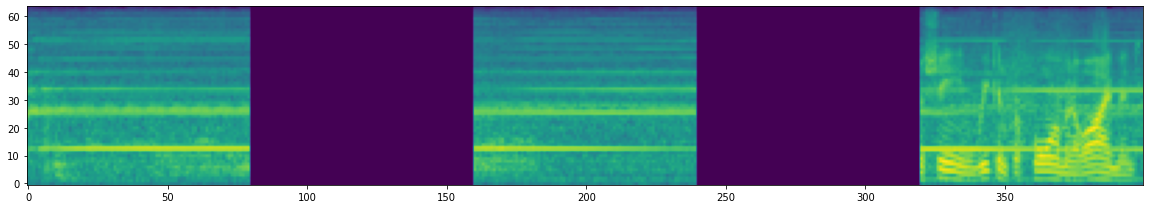

In [24]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [25]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.35995739604830135 0.7975813427180773 1.1780584903893583
 Average | 0.360 | 0.798 | 1.178 
---------+-------+-------+-------
       0 | 0.846 | 0.894 | 1.764 
       1 | 0.077 | 0.382 |-0.426 
       2 | 0.091 | 0.567 | 0.240 
       3 | 0.336 | 0.722 | 0.834 
       4 | 0.179 | 0.756 | 0.981 
       5 | 0.065 | 0.694 | 0.715 
       6 | 0.411 | 0.932 | 2.105 
       7 | 0.343 | 0.887 | 1.709 
       8 | 0.119 | 0.639 | 0.502 
       9 | 0.089 | 0.624 | 0.447 
      10 | 0.104 | 0.665 | 0.602 
      11 | 0.203 | 0.773 | 1.058 
      12 | 0.796 | 0.988 | 3.193 
      13 | 0.436 | 0.953 | 2.362 
      14 | 0.258 | 0.791 | 1.148 
      15 | 0.753 | 0.949 | 2.314 
      16 | 0.342 | 0.801 | 1.196 
      17 | 0.553 | 0.926 | 2.042 
      18 | 0.117 | 0.773 | 1.059 
      19 | 0.191 | 0.741 | 0.914 
      20 | 0.311 | 0.875 | 1.626 
      21 | 0.155 | 

<h>First 5s</h>

In [26]:
new_gas_eval = []

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    record.mask[:200]=True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

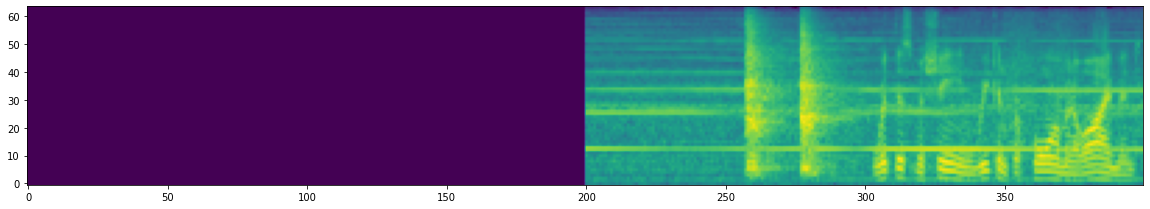

In [27]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [28]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.32124778555257777 0.7483250180536296 0.9464314994814018
 Average | 0.321 | 0.748 | 0.946 
---------+-------+-------+-------
       0 | 0.809 | 0.872 | 1.608 
       1 | 0.063 | 0.349 |-0.547 
       2 | 0.084 | 0.564 | 0.229 
       3 | 0.312 | 0.670 | 0.624 
       4 | 0.140 | 0.650 | 0.543 
       5 | 0.050 | 0.645 | 0.526 
       6 | 0.298 | 0.863 | 1.548 
       7 | 0.212 | 0.874 | 1.623 
       8 | 0.114 | 0.563 | 0.224 
       9 | 0.100 | 0.645 | 0.527 
      10 | 0.075 | 0.635 | 0.489 
      11 | 0.131 | 0.711 | 0.787 
      12 | 0.717 | 0.960 | 2.484 
      13 | 0.434 | 0.926 | 2.042 
      14 | 0.262 | 0.777 | 1.078 
      15 | 0.648 | 0.878 | 1.651 
      16 | 0.308 | 0.799 | 1.183 
      17 | 0.410 | 0.895 | 1.775 
      18 | 0.112 | 0.665 | 0.601 
      19 | 0.158 | 0.714 | 0.797 
      20 | 0.311 | 0.823 | 1.311 
      21 | 0.139 | 

<h>mid 5s</h>

In [29]:
new_gas_eval = []

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    record.mask[100:300]=True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

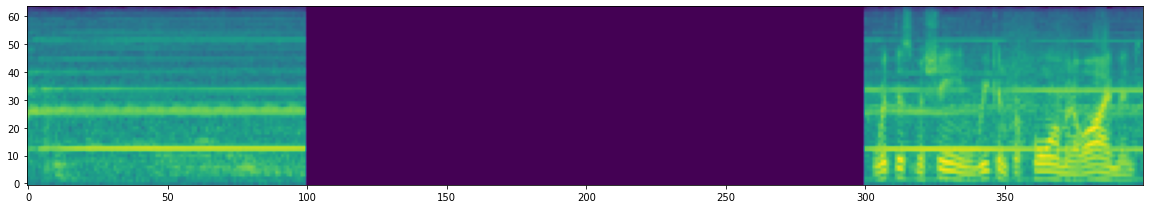

In [30]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [31]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.33696330913648664 0.7723762341167693 1.0559865632828016
 Average | 0.337 | 0.772 | 1.056 
---------+-------+-------+-------
       0 | 0.811 | 0.875 | 1.628 
       1 | 0.044 | 0.362 |-0.499 
       2 | 0.091 | 0.569 | 0.246 
       3 | 0.297 | 0.672 | 0.632 
       4 | 0.180 | 0.759 | 0.995 
       5 | 0.061 | 0.660 | 0.583 
       6 | 0.347 | 0.878 | 1.649 
       7 | 0.312 | 0.880 | 1.660 
       8 | 0.100 | 0.632 | 0.477 
       9 | 0.091 | 0.608 | 0.386 
      10 | 0.097 | 0.665 | 0.601 
      11 | 0.146 | 0.747 | 0.941 
      12 | 0.721 | 0.960 | 2.482 
      13 | 0.396 | 0.945 | 2.255 
      14 | 0.170 | 0.723 | 0.839 
      15 | 0.723 | 0.918 | 1.970 
      16 | 0.334 | 0.801 | 1.198 
      17 | 0.493 | 0.912 | 1.913 
      18 | 0.139 | 0.778 | 1.081 
      19 | 0.177 | 0.713 | 0.795 
      20 | 0.317 | 0.845 | 1.436 
      21 | 0.151 | 

<h>last 5s</h>

In [32]:
new_gas_eval = []

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    record.mask[200:400]=True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

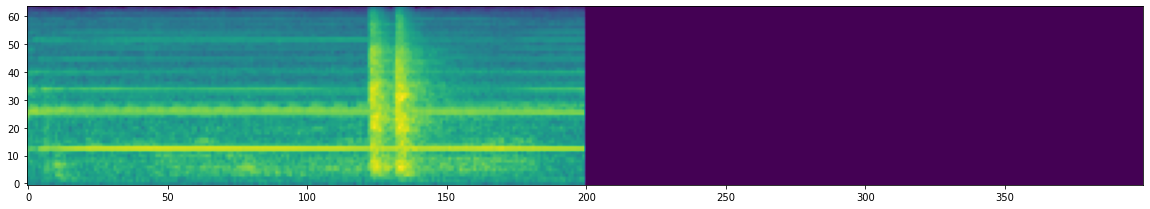

In [33]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [34]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.3305352507231419 0.7561324459813648 0.9813449243369501
 Average | 0.331 | 0.756 | 0.981 
---------+-------+-------+-------
       0 | 0.822 | 0.880 | 1.664 
       1 | 0.037 | 0.353 |-0.535 
       2 | 0.083 | 0.505 | 0.018 
       3 | 0.231 | 0.669 | 0.620 
       4 | 0.133 | 0.722 | 0.835 
       5 | 0.050 | 0.627 | 0.459 
       6 | 0.326 | 0.832 | 1.360 
       7 | 0.269 | 0.839 | 1.401 
       8 | 0.114 | 0.608 | 0.387 
       9 | 0.090 | 0.603 | 0.368 
      10 | 0.098 | 0.690 | 0.701 
      11 | 0.191 | 0.760 | 0.997 
      12 | 0.837 | 0.990 | 3.287 
      13 | 0.319 | 0.870 | 1.590 
      14 | 0.168 | 0.717 | 0.810 
      15 | 0.793 | 0.960 | 2.478 
      16 | 0.323 | 0.757 | 0.986 
      17 | 0.556 | 0.879 | 1.652 
      18 | 0.175 | 0.779 | 1.089 
      19 | 0.202 | 0.650 | 0.543 
      20 | 0.303 | 0.826 | 1.326 
      21 | 0.206 | 0

<h>Every 1s</h1>

In [35]:
new_gas_eval = []
time_frame = 400
step = 40
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

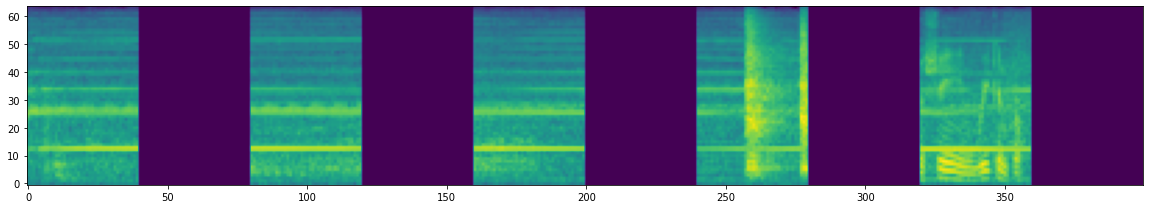

In [36]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [37]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.3210283665880016 0.7673364966009267 1.0325220757031952
 Average | 0.321 | 0.767 | 1.033 
---------+-------+-------+-------
       0 | 0.824 | 0.881 | 1.667 
       1 | 0.069 | 0.352 |-0.538 
       2 | 0.072 | 0.524 | 0.086 
       3 | 0.261 | 0.667 | 0.610 
       4 | 0.116 | 0.723 | 0.835 
       5 | 0.059 | 0.683 | 0.673 
       6 | 0.335 | 0.848 | 1.452 
       7 | 0.272 | 0.841 | 1.414 
       8 | 0.129 | 0.600 | 0.357 
       9 | 0.100 | 0.635 | 0.487 
      10 | 0.089 | 0.700 | 0.740 
      11 | 0.178 | 0.716 | 0.809 
      12 | 0.765 | 0.978 | 2.838 
      13 | 0.333 | 0.940 | 2.198 
      14 | 0.189 | 0.743 | 0.924 
      15 | 0.722 | 0.933 | 2.121 
      16 | 0.345 | 0.790 | 1.139 
      17 | 0.551 | 0.924 | 2.029 
      18 | 0.099 | 0.724 | 0.843 
      19 | 0.138 | 0.713 | 0.794 
      20 | 0.348 | 0.869 | 1.588 
      21 | 0.128 | 0

<h>Every 0.5s</h1>

In [38]:
new_gas_eval = []
time_frame = 400
step = 20
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

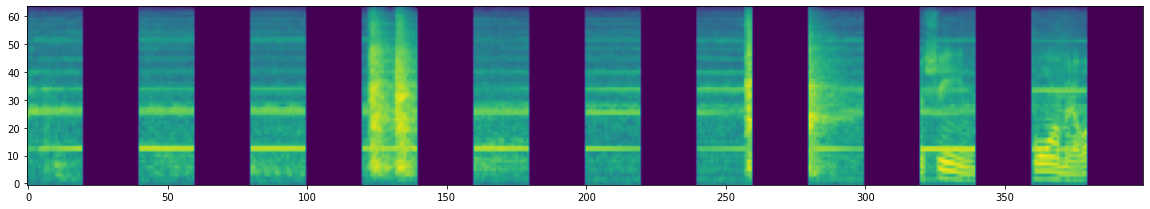

In [39]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [40]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.23570063383879714 0.6862603264003507 0.6862863539488554
 Average | 0.236 | 0.686 | 0.686 
---------+-------+-------+-------
       0 | 0.758 | 0.820 | 1.293 
       1 | 0.048 | 0.253 |-0.938 
       2 | 0.078 | 0.550 | 0.179 
       3 | 0.236 | 0.620 | 0.432 
       4 | 0.153 | 0.659 | 0.581 
       5 | 0.052 | 0.654 | 0.559 
       6 | 0.227 | 0.814 | 1.262 
       7 | 0.181 | 0.775 | 1.067 
       8 | 0.090 | 0.602 | 0.365 
       9 | 0.087 | 0.565 | 0.231 
      10 | 0.069 | 0.645 | 0.527 
      11 | 0.081 | 0.644 | 0.522 
      12 | 0.616 | 0.948 | 2.303 
      13 | 0.243 | 0.893 | 1.755 
      14 | 0.140 | 0.674 | 0.638 
      15 | 0.734 | 0.947 | 2.280 
      16 | 0.343 | 0.771 | 1.048 
      17 | 0.405 | 0.853 | 1.484 
      18 | 0.092 | 0.714 | 0.799 
      19 | 0.126 | 0.678 | 0.654 
      20 | 0.182 | 0.819 | 1.288 
      21 | 0.066 | 

<h>Every 0.25s</h1>

In [41]:
new_gas_eval = []
time_frame = 400
step = 10
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

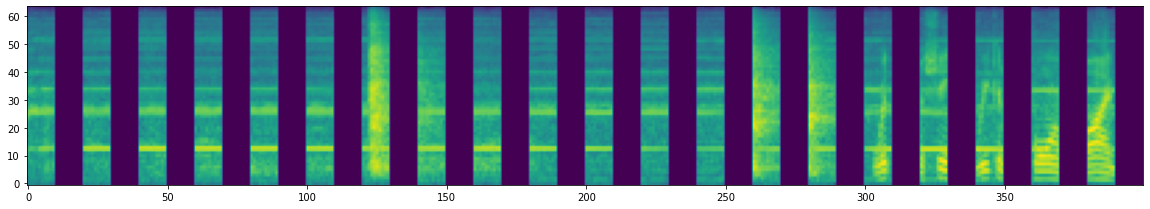

In [42]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [43]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.051576891893948346 0.2787860163280582 -0.8293679007988354
 Average | 0.052 | 0.279 |-0.829 
---------+-------+-------+-------
       0 | 0.579 | 0.643 | 0.518 
       1 | 0.016 | 0.077 |-2.018 
       2 | 0.021 | 0.228 |-1.057 
       3 | 0.089 | 0.320 |-0.662 
       4 | 0.020 | 0.266 |-0.884 
       5 | 0.024 | 0.352 |-0.538 
       6 | 0.047 | 0.568 | 0.242 
       7 | 0.022 | 0.276 |-0.843 
       8 | 0.015 | 0.081 |-1.981 
       9 | 0.017 | 0.169 |-1.355 
      10 | 0.016 | 0.166 |-1.372 
      11 | 0.014 | 0.080 |-1.987 
      12 | 0.021 | 0.292 |-0.775 
      13 | 0.026 | 0.228 |-1.056 
      14 | 0.017 | 0.191 |-1.238 
      15 | 0.391 | 0.825 | 1.323 
      16 | 0.091 | 0.512 | 0.043 
      17 | 0.085 | 0.556 | 0.199 
      18 | 0.077 | 0.456 |-0.157 
      19 | 0.053 | 0.350 |-0.543 
      20 | 0.050 | 0.500 | 0.000 
      21 | 0.050 

<h>Every 0.125s</h1>

In [44]:
new_gas_eval = []
time_frame = 400
step = 5
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

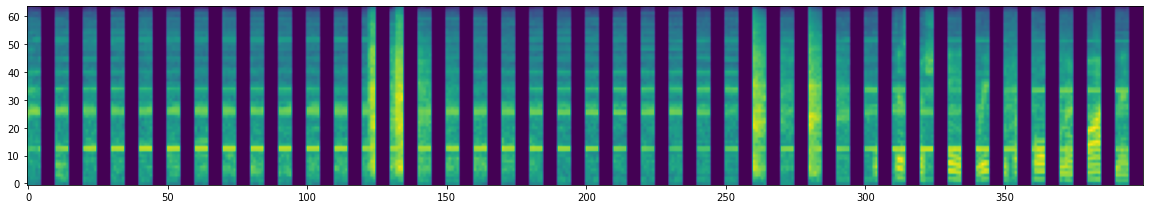

In [45]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [46]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.032220267439435804 0.1869466467816972 -1.2575247774221272
 Average | 0.032 | 0.187 |-1.258 
---------+-------+-------+-------
       0 | 0.525 | 0.525 | 0.089 
       1 | 0.016 | 0.071 |-2.077 
       2 | 0.021 | 0.160 |-1.407 
       3 | 0.064 | 0.185 |-1.269 
       4 | 0.018 | 0.209 |-1.148 
       5 | 0.019 | 0.180 |-1.294 
       6 | 0.021 | 0.337 |-0.594 
       7 | 0.015 | 0.061 |-2.187 
       8 | 0.015 | 0.073 |-2.060 
       9 | 0.017 | 0.174 |-1.329 
      10 | 0.015 | 0.122 |-1.644 
      11 | 0.014 | 0.073 |-2.051 
      12 | 0.016 | 0.115 |-1.698 
      13 | 0.033 | 0.344 |-0.570 
      14 | 0.015 | 0.040 |-2.479 
      15 | 0.213 | 0.797 | 1.173 
      16 | 0.043 | 0.323 |-0.648 
      17 | 0.026 | 0.373 |-0.458 
      18 | 0.023 | 0.302 |-0.734 
      19 | 0.019 | 0.207 |-1.156 
      20 | 0.022 | 0.269 |-0.872 
      21 | 0.020 

<h>concat 0.125s</h>

In [47]:
new_gas_eval = []
time_frame = 400
step = 5
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.compressed().reshape(half,n_mel)
    fill_matrix = numpy.full((half,n_mel), silence_val)
#     print('shape', fill_matrix.shape)
    mask_record = numpy.vstack((mask_record, fill_matrix))
#     record.mask[100:300]=True
#     mask_record = record[~record.mask]
#     print(mask_record.shape)
#     mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

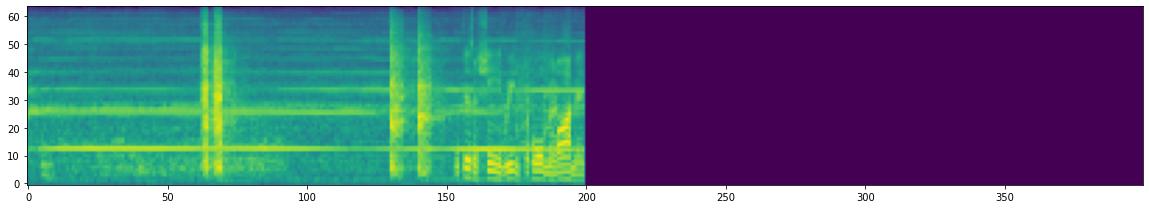

In [48]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [49]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.2932787226814531 0.7466096141638153 0.9388379327945799
 Average | 0.293 | 0.747 | 0.939 
---------+-------+-------+-------
       0 | 0.778 | 0.847 | 1.448 
       1 | 0.093 | 0.380 |-0.433 
       2 | 0.091 | 0.499 |-0.003 
       3 | 0.224 | 0.612 | 0.404 
       4 | 0.139 | 0.772 | 1.056 
       5 | 0.075 | 0.684 | 0.676 
       6 | 0.236 | 0.863 | 1.547 
       7 | 0.355 | 0.840 | 1.409 
       8 | 0.101 | 0.607 | 0.383 
       9 | 0.106 | 0.611 | 0.397 
      10 | 0.099 | 0.651 | 0.549 
      11 | 0.152 | 0.751 | 0.958 
      12 | 0.651 | 0.954 | 2.387 
      13 | 0.377 | 0.948 | 2.303 
      14 | 0.174 | 0.757 | 0.986 
      15 | 0.675 | 0.940 | 2.195 
      16 | 0.285 | 0.765 | 1.023 
      17 | 0.453 | 0.857 | 1.507 
      18 | 0.098 | 0.648 | 0.536 
      19 | 0.121 | 0.661 | 0.586 
      20 | 0.290 | 0.803 | 1.203 
      21 | 0.116 | 0

<h>concat 0.25s</h>

In [50]:
new_gas_eval = []
time_frame = 400
step = 10
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.compressed().reshape(half,n_mel)
    fill_matrix = numpy.full((half,n_mel), silence_val)
#     print('shape', fill_matrix.shape)
    mask_record = numpy.vstack((mask_record, fill_matrix))
#     record.mask[100:300]=True
#     mask_record = record[~record.mask]
#     print(mask_record.shape)
#     mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

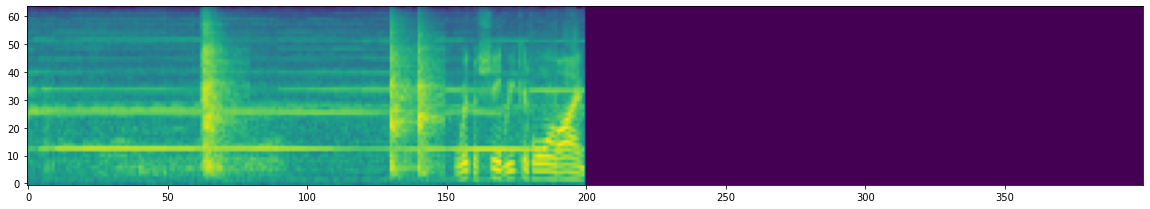

In [51]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [52]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.31290945253931635 0.765514800906831 1.0241102451258672
 Average | 0.313 | 0.766 | 1.024 
---------+-------+-------+-------
       0 | 0.795 | 0.861 | 1.533 
       1 | 0.088 | 0.361 |-0.503 
       2 | 0.062 | 0.531 | 0.109 
       3 | 0.252 | 0.690 | 0.701 
       4 | 0.177 | 0.778 | 1.084 
       5 | 0.111 | 0.720 | 0.826 
       6 | 0.334 | 0.863 | 1.547 
       7 | 0.364 | 0.891 | 1.741 
       8 | 0.109 | 0.575 | 0.266 
       9 | 0.078 | 0.591 | 0.324 
      10 | 0.098 | 0.693 | 0.714 
      11 | 0.129 | 0.726 | 0.849 
      12 | 0.754 | 0.988 | 3.190 
      13 | 0.436 | 0.950 | 2.329 
      14 | 0.233 | 0.777 | 1.079 
      15 | 0.677 | 0.946 | 2.274 
      16 | 0.341 | 0.792 | 1.153 
      17 | 0.496 | 0.893 | 1.756 
      18 | 0.139 | 0.735 | 0.887 
      19 | 0.185 | 0.688 | 0.693 
      20 | 0.285 | 0.866 | 1.563 
      21 | 0.161 | 0

<h>concat 0.5s</h>

In [53]:
new_gas_eval = []
time_frame = 400
step = 20
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.compressed().reshape(half,n_mel)
    fill_matrix = numpy.full((half,n_mel), silence_val)
#     print('shape', fill_matrix.shape)
    mask_record = numpy.vstack((mask_record, fill_matrix))
#     record.mask[100:300]=True
#     mask_record = record[~record.mask]
#     print(mask_record.shape)
#     mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

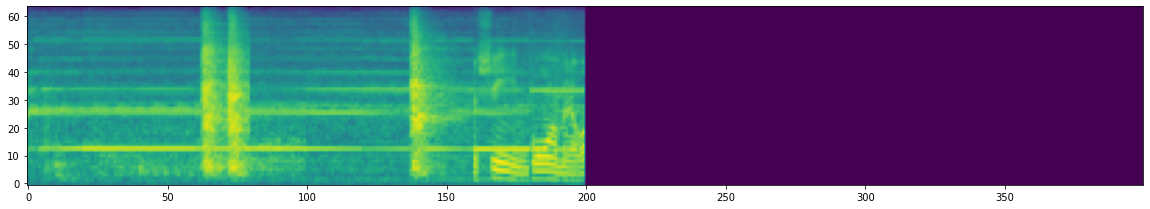

In [54]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [55]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.33280764742258145 0.7805191406641414 1.0945273371806248
 Average | 0.333 | 0.781 | 1.095 
---------+-------+-------+-------
       0 | 0.821 | 0.875 | 1.630 
       1 | 0.104 | 0.353 |-0.532 
       2 | 0.084 | 0.538 | 0.135 
       3 | 0.276 | 0.680 | 0.661 
       4 | 0.170 | 0.786 | 1.120 
       5 | 0.119 | 0.690 | 0.703 
       6 | 0.275 | 0.874 | 1.618 
       7 | 0.381 | 0.881 | 1.671 
       8 | 0.102 | 0.598 | 0.353 
       9 | 0.094 | 0.635 | 0.486 
      10 | 0.080 | 0.704 | 0.756 
      11 | 0.131 | 0.716 | 0.809 
      12 | 0.781 | 0.990 | 3.285 
      13 | 0.464 | 0.955 | 2.399 
      14 | 0.221 | 0.805 | 1.216 
      15 | 0.707 | 0.955 | 2.403 
      16 | 0.341 | 0.794 | 1.158 
      17 | 0.493 | 0.889 | 1.730 
      18 | 0.157 | 0.783 | 1.107 
      19 | 0.174 | 0.699 | 0.738 
      20 | 0.204 | 0.844 | 1.428 
      21 | 0.120 | 

<h>concat 1s</h>

In [56]:
new_gas_eval = []
time_frame = 400
step = 40
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.compressed().reshape(half,n_mel)
    fill_matrix = numpy.full((half,n_mel), silence_val)
#     print('shape', fill_matrix.shape)
    mask_record = numpy.vstack((mask_record, fill_matrix))
#     record.mask[100:300]=True
#     mask_record = record[~record.mask]
#     print(mask_record.shape)
#     mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

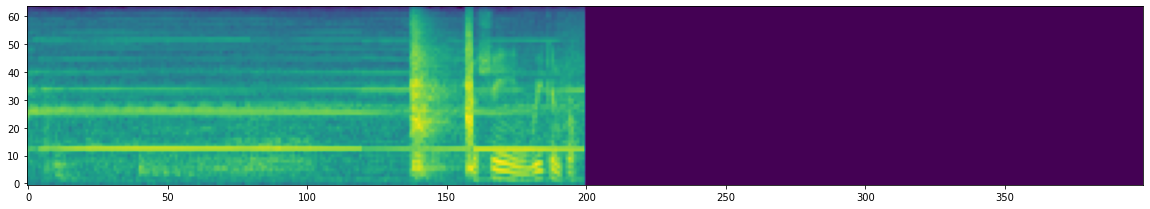

In [57]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [58]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.34011015785848636 0.783532396535551 1.1089962844994448
 Average | 0.340 | 0.784 | 1.109 
---------+-------+-------+-------
       0 | 0.840 | 0.893 | 1.755 
       1 | 0.071 | 0.359 |-0.512 
       2 | 0.089 | 0.524 | 0.085 
       3 | 0.274 | 0.675 | 0.642 
       4 | 0.148 | 0.775 | 1.069 
       5 | 0.088 | 0.668 | 0.616 
       6 | 0.318 | 0.866 | 1.568 
       7 | 0.353 | 0.873 | 1.611 
       8 | 0.152 | 0.649 | 0.542 
       9 | 0.104 | 0.640 | 0.505 
      10 | 0.099 | 0.694 | 0.715 
      11 | 0.147 | 0.725 | 0.846 
      12 | 0.805 | 0.971 | 2.683 
      13 | 0.377 | 0.937 | 2.162 
      14 | 0.199 | 0.767 | 1.031 
      15 | 0.755 | 0.968 | 2.613 
      16 | 0.353 | 0.804 | 1.211 
      17 | 0.520 | 0.917 | 1.963 
      18 | 0.147 | 0.784 | 1.112 
      19 | 0.177 | 0.730 | 0.866 
      20 | 0.326 | 0.876 | 1.633 
      21 | 0.149 | 0

<h>White noise</h>

In [59]:
import numpy as np
new_gas_eval = []
for record in gas_eval_x1:
    record += np.random.normal(0, 0.1, (400,64))
    new_gas_eval.append(record)
new_gas_eval = numpy.array(new_gas_eval)

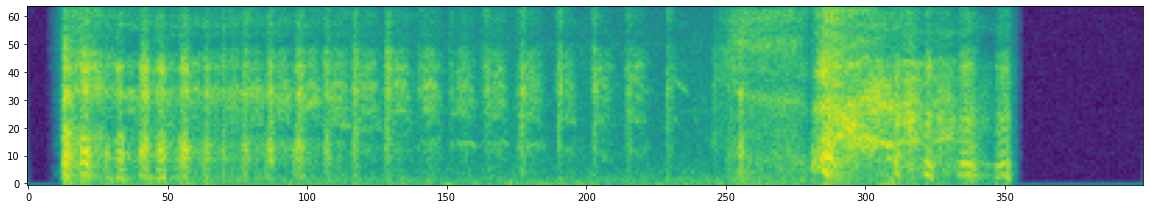

In [60]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[2].T, origin='lower')

In [61]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.24693690308780494 0.6944743902757302 0.7192315176800845
 Average | 0.247 | 0.694 | 0.719 
---------+-------+-------+-------
       0 | 0.803 | 0.862 | 1.539 
       1 | 0.038 | 0.298 |-0.750 
       2 | 0.098 | 0.555 | 0.195 
       3 | 0.234 | 0.669 | 0.618 
       4 | 0.246 | 0.762 | 1.010 
       5 | 0.059 | 0.633 | 0.479 
       6 | 0.288 | 0.895 | 1.774 
       7 | 0.426 | 0.887 | 1.711 
       8 | 0.030 | 0.434 |-0.236 
       9 | 0.043 | 0.463 |-0.133 
      10 | 0.137 | 0.583 | 0.298 
      11 | 0.107 | 0.604 | 0.374 
      12 | 0.699 | 0.973 | 2.730 
      13 | 0.452 | 0.929 | 2.077 
      14 | 0.202 | 0.807 | 1.226 
      15 | 0.638 | 0.896 | 1.781 
      16 | 0.368 | 0.771 | 1.051 
      17 | 0.508 | 0.902 | 1.826 
      18 | 0.146 | 0.788 | 1.128 
      19 | 0.141 | 0.795 | 1.165 
      20 | 0.259 | 0.886 | 1.708 
      21 | 0.121 | 

In [14]:
from torch.cuda.amp import autocast,GradScaler

In [15]:
import numpy as np
np.unique(gas_eval_y.astype('float16'))
print(np.min(gas_eval_x1), np.max(gas_eval_x1))

-2.2922494 1.4197426


In [16]:
pgd_dataset = torch.utils.data.TensorDataset(torch.from_numpy(gas_eval_x1[:]), torch.from_numpy(gas_eval_y[:].astype('float32')))
pgd_dataloader = torch.utils.data.DataLoader(pgd_dataset, batch_size=50, shuffle=True)

In [17]:
def pgd(model, dataloader, delta_global, num_steps, step_size, step_norm, eps, eps_norm, x_min, x_max, y_target=None):
    """Performs the projected gradient descent attack on a batch of images."""
    model.cuda().eval()
    targeted = y_target is not None
    criterion = nn.BCEWithLogitsLoss().cuda()
    loss_global = 0
    for epoch in range(num_steps):
        torch.cuda.empty_cache()
        loss_global = 0
        dataiter = iter(dataloader)
        for step, (feat_a, y) in enumerate(dataiter):
            feat_a = feat_a.cuda()
            
            x_adv_1 = feat_a + delta_global #.to(x.device)
            x_adv_1 = x_adv_1.clamp(x_min, x_max)
            # only video
           
            N_1, T_1, V_1 = x_adv_1.shape
#             print(N_1,T_1,V_1)

            #######   data loaded ###################
            _x_adv_1 = x_adv_1.clone().detach().requires_grad_(True).cuda()

            #######   get gradient #################
#             with torch.no_grad():
#             model.train()# double check
            with autocast():
                out = model(_x_adv_1)
#                 print(out)
#                 out = torch.sigmoid(out)
#                 epsilon = 1e-7
#                 out = torch.clamp(out, epsilon, 1. - epsilon)
#                 temp_out = out.clamp(0,1).cuda()
#                 print(temp_out.shape, y.shape, temp_out.max(), temp_out.min())
#                 print(temp_out.shape, y.shape)

                loss = criterion(out, y.to('cuda', non_blocking=True))
                loss_global += loss.item()
#                 print(loss.item(), loss_global)
                loss.backward()
#             break
            ########   updated _x_adv ###############
            with torch.no_grad():
            # Force the gradient step to be a fixed size in a certain norm
                if step_norm == 'inf':
                    gradients = _x_adv_1.grad.sign() * step_size
                else:
                    # The grad is normalized here.
                    # gradients = _x_adv.grad 
                    # Only normalize w.r.t. to feats at a timestep
                    gradients = _x_adv_1.grad/_x_adv_1.grad.norm(step_norm, dim=-1).view(-1, T_1, 1)
                    gradients *= step_size
                if targeted:
                    # Targeted: Gradient descent with on the loss of the (incorrect) target label
                    # w.r.t. the image data
                    x_adv_1 -= gradients
                else:
                    # Untargeted: Gradient ascent on the loss of the correct label w.r.t.
                    # the model parameters
                    x_adv_1 += gradients
            # Project back into l_norm ball and correct range
            if eps_norm == 'inf':
                # Workaround as PyTorch doesn't have elementwise clip
                x_adv_1 = torch.max(torch.min(x_adv_1, feat_a + eps), feat_a - eps)
                delta = x_adv_1 - feat_a
            else:
                delta = x_adv_1 - feat_a
            # Assume x and x_adv are batched tensors where the first dimension is
            # a batch dimension
            # 100 10 2048
#             print(delta)
            mask = delta.view(delta.shape[0], -1).norm(float(eps_norm), dim=1) <= eps #100*(20480) => 100
            scaling_factor = delta.view(delta.shape[0], T_1, -1).norm(float(eps_norm), dim=-1) #100 10 2048 => 100 40
            scaling_factor[mask] = eps
#             print(scaling_factor)
            # .view() assumes batched images as a 4D Tensor
            delta *= eps / (scaling_factor+1e-7).view(-1, T_1, 1)
#             print(delta)
#             return delta
            delta = delta.float()
            delta = torch.mean(delta,0)
#             print(delta)
            delta_global += delta * N_1 / 20123
#             print(delta_global)
            for name, param in model.named_parameters():
                if param.requires_grad:
                    try:
                        param.grad.zero_()
                    except:
                        pass
        print(f'global loss:{loss_global}')
    return delta_global

In [18]:
torch.cuda.empty_cache()
perturb = pgd(model, pgd_dataloader, torch.zeros((400,64)).cuda(), num_steps=20, step_size=0.01, step_norm='inf', eps= 0.3, eps_norm='2', x_min=np.min(gas_eval_x1), x_max=np.max(gas_eval_x1), y_target=None )

global loss:5.295698743313551
global loss:5.5707350615412
global loss:6.78319470025599
global loss:8.215208817273378
global loss:9.366630194708705
global loss:10.277056638151407
global loss:10.934405330568552
global loss:11.399416157975793
global loss:11.759801318868995
global loss:12.064545908942819
global loss:12.347336048260331
global loss:12.607531506568193
global loss:12.837746180593967
global loss:13.02858018875122
global loss:13.173326309770346
global loss:13.296473555266857
global loss:13.389330299571157
global loss:13.464445307850838
global loss:13.521782860159874
global loss:13.573904294520617


In [19]:
new_gas_eval = perturb.cpu().numpy() + gas_eval_x1

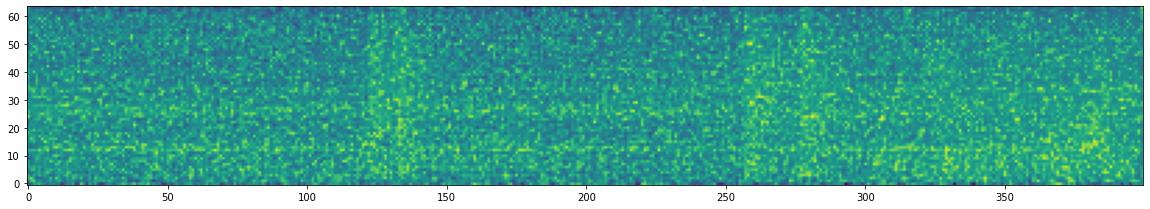

In [20]:

plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [21]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.024063530065962173 0.11309551821229344 -1.7115222531613596
 Average | 0.024 | 0.113 |-1.712 
---------+-------+-------+-------
       0 | 0.415 | 0.354 |-0.528 
       1 | 0.015 | 0.015 |-3.062 
       2 | 0.018 | 0.083 |-1.956 
       3 | 0.050 | 0.106 |-1.763 
       4 | 0.017 | 0.177 |-1.313 
       5 | 0.049 | 0.462 |-0.136 
       6 | 0.016 | 0.184 |-1.271 
       7 | 0.101 | 0.455 |-0.161 
       8 | 0.017 | 0.131 |-1.588 
       9 | 0.019 | 0.205 |-1.164 
      10 | 0.015 | 0.072 |-2.063 
      11 | 0.014 | 0.079 |-2.001 
      12 | 0.022 | 0.341 |-0.580 
      13 | 0.017 | 0.171 |-1.342 
      14 | 0.017 | 0.135 |-1.562 
      15 | 0.028 | 0.487 |-0.047 
      16 | 0.028 | 0.061 |-2.191 
      17 | 0.016 | 0.099 |-1.820 
      18 | 0.015 | 0.069 |-2.094 
      19 | 0.015 | 0.044 |-2.408 
      20 | 0.015 | 0.026 |-2.741 
      21 | 0.015

In [22]:
torch.cuda.empty_cache()
perturb = pgd(model, pgd_dataloader, torch.zeros((400,64)).cuda(), num_steps=20, step_size=0.01, step_norm=2, eps= 0.3, eps_norm='2', x_min=np.min(gas_eval_x1), x_max=np.max(gas_eval_x1), y_target=None )

global loss:nan
global loss:nan
global loss:nan
global loss:nan
global loss:nan
global loss:nan
global loss:nan
global loss:nan
global loss:nan
global loss:nan
global loss:nan
global loss:nan
global loss:nan
global loss:nan
global loss:nan
global loss:nan
global loss:nan
global loss:nan
global loss:nan
global loss:nan


In [23]:
new_gas_eval = perturb.cpu().numpy() + gas_eval_x1

In [24]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.03718780962615604 0.5 0.0
 Average | 0.037 | 0.500 | 0.000 
---------+-------+-------+-------
       0 | 0.500 | 0.500 | 0.000 
       1 | 0.030 | 0.500 | 0.000 
       2 | 0.034 | 0.500 | 0.000 
       3 | 0.093 | 0.500 | 0.000 
       4 | 0.028 | 0.500 | 0.000 
       5 | 0.028 | 0.500 | 0.000 
       6 | 0.028 | 0.500 | 0.000 
       7 | 0.028 | 0.500 | 0.000 
       8 | 0.028 | 0.500 | 0.000 
       9 | 0.028 | 0.500 | 0.000 
      10 | 0.028 | 0.500 | 0.000 
      11 | 0.027 | 0.500 | 0.000 
      12 | 0.028 | 0.500 | 0.000 
      13 | 0.028 | 0.500 | 0.000 
      14 | 0.029 | 0.500 | 0.000 
      15 | 0.029 | 0.500 | 0.000 
      16 | 0.054 | 0.500 | 0.000 
      17 | 0.029 | 0.500 | 0.000 
      18 | 0.028 | 0.500 | 0.000 
      19 | 0.028 | 0.500 | 0.000 
      20 | 0.029 | 0.500 | 0.000 
      21 | 0.028 | 0.500 | 0.000 
      22 | 0.02

/jet/home/billyli/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/jet/home/billyli/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


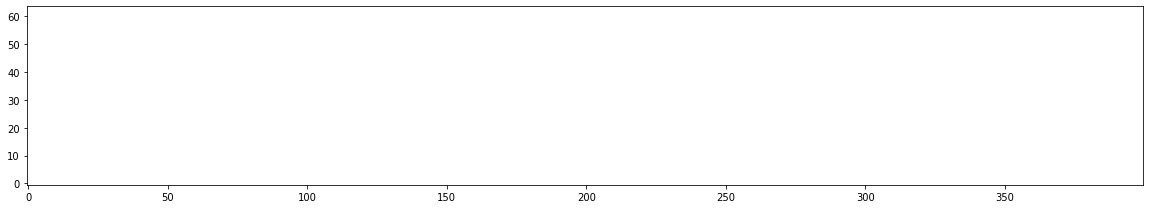

In [25]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

<h>Strong</h1>

In [26]:
hf_val_eval_path = os.path.join(local, 'data_64_400_strong_cleaned.h5')
mu_val=args.mean
sigma_val=args.std
                            
def bulk_load2(file_path, mu, sigma):
    hf_val_eval = h5py.File(file_path, 'r')
    feat_a = (hf_val_eval['feat_a'][:]*2-mu)/(2 * sigma)
    labels = hf_val_eval['labels'][:]
    hf_val_eval.close()
    return feat_a.astype('float32'), labels.astype('bool')

gas_eval_x1, gas_eval_y = bulk_load2(hf_val_eval_path, mu_val, sigma_val)

In [27]:
result = []
batch_size =100
x = gas_eval_x1 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]

total num of batches during testing 202


In [28]:
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.16163189068756134 0.3682575491259574 -0.4758430115681536
 Average | 0.162 | 0.368 |-0.476 
---------+-------+-------+-------
       0 | 0.781 | 0.821 | 1.302 
       1 | 0.034 | 0.246 |-0.973 
       2 | 0.042 | 0.277 |-0.838 
       3 | 0.197 | 0.380 |-0.433 
       4 | 0.165 | 0.384 |-0.418 
       5 | 0.060 | 0.447 |-0.187 
       6 | 0.226 | 0.502 | 0.007 
       7 | 0.149 | 0.539 | 0.140 
       8 | 0.057 | 0.195 |-1.216 
       9 | 0.040 | 0.210 |-1.142 
      10 | 0.075 | 0.360 |-0.506 
      11 | 0.049 | 0.318 |-0.670 
      12 | 0.276 | 0.358 |-0.515 
      13 | 0.070 | 0.427 |-0.261 
      14 | 0.238 | 0.564 | 0.226 
      15 | 0.414 | 0.494 |-0.022 
      16 | 0.169 | 0.394 |-0.381 
      17 | 0.179 | 0.484 |-0.057 
      18 | 0.083 | 0.464 |-0.126 
      19 | 0.115 | 0.392 |-0.387 
      20 | 0.164 | 0.465 |-0.123 
      21 | 0.081 | 0.458 |-0.148 
      22 | 0.310 | 0.629